In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Generator, Callable

# Подготовка данных

## Опреределние используемых функций

In [28]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df

def remove_outliers_with_datetime(df: pd.DataFrame, threshold_multiplier: float) -> pd.DataFrame:
    # Копируем DataFrame, чтобы сохранить оригинальные данные
    filtered_df = df.copy()
    # Список для сохранения индексов строк, которые не являются выбросами
    valid_indices = []

    # Проходим по всем столбцам, кроме последнего (DateTime)
    for column in df.columns[:-1]:
        # Вычисление среднего и стандартного отклонения
        mean = df[column].mean()
        std = df[column].std()

        # Определение границ для выбросов
        upper_threshold = mean + threshold_multiplier * std
        lower_threshold = mean - threshold_multiplier * std

        # Находим валидные строки, которые не являются выбросами
        valid_mask = (df[column] <= upper_threshold) & (df[column] >= lower_threshold)
        
        # Сохраняем индексы валидных строк для текущего столбца
        if not valid_indices:
            # Если список индексов еще пуст, инициализируем его
            valid_indices = df.index[valid_mask].tolist()
        else:
            # Объединяем индексы с уже существующими, оставляя только те, которые валидны во всех колонках
            valid_indices = [index for index in valid_indices if index in df.index[valid_mask]]

    # Отфильтровываем DataFrame, оставляя только строки с валидными индексами
    filtered_df = df.loc[valid_indices].reset_index(drop=True)

    return filtered_df


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, diff1: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            # if timeX - timeY < diff2:
            #      tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
            #      X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
  
        if (timeY - timeX > diff2) or (timeY - timeX < diff1):
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

## Загрузка файлов

In [29]:
df_Y1 = load_file('Исходные данные/Лабораторные анализы Давление насыщенных паров в продукте, зимний период.xlsx')
df_Y2 = load_file('Исходные данные/Лабораторные анализы Конец кипения легкого бензина.xlsx')
df_Y3 = load_file('Исходные данные/Лабораторные анализы Содержание олефинов в продукте.xlsx')

df_X1 = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx'),3)
df_X2 = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx'),3)
df_X3 = remove_outliers_with_datetime(load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx'),3)

In [30]:
df_Y1

Давление насыщенных паров, зимний период, кПа            DateTime
0                                             49.8 2022-01-01 11:21:00
1                                             52.3 2022-01-02 10:50:00
2                                             50.7 2022-01-03 10:24:48
3                                             52.6 2022-01-04 11:12:49
4                                             54.7 2022-01-05 10:23:28
..                                             ...                 ...
291                                           59.3 2023-12-05 11:30:47
292                                           57.4 2023-12-07 10:21:11
307                                           56.9 2024-01-30 11:27:17
308                                           60.7 2024-02-01 11:17:48
309                                           57.4 2024-02-06 11:46:26

[134 rows x 2 columns]

In [31]:
df_X1

Расход бензина ККР на установку  Расход нафты ККР на установку  \
0                                85.87                           9.89   
1                                86.24                           8.30   
2                                87.70                           8.36   
3                                87.86                           8.60   
4                                87.53                           9.04   
...                                ...                            ...   
11565                           103.80                           0.00   
11566                           103.66                           0.00   
11567                           103.14                           0.00   
11568                           103.68                           0.00   
11569                           101.99                           0.00   

       Расход бензина на рециркуляцию от Е-1205  \
0                                          0.00   
1                                          0.00   
2                                          0.00   
3                                          0.00   
4                                          0.00   
...                                         ...   
11565                                      3.93   
11566                                      1.28   
11567                                      0.20   
11568                                      1.28   
11569                                      0.00   

       Температура бензина ККР на установку  Давление в емкости V-1101  \
0                                     29.25                        1.2   
1                                     29.33                        1.2   
2                                     29.34                        1.2   
3                                     29.41                        1.2   
4                                     29.92                        1.2   
...                                     ...                        ...   
11565                                 35.60                        1.2   
11566                                 35.85                        1.2   
11567                                 35.53                        1.2   
11568                                 35.54                        1.2   
11569                                 35.35                        1.2   

       Расход сырья после Р-1101  Показатель соотношения водород к углероду  \
0                         139.21                                       6.68   
1                         138.03                                       6.74   
2                         138.13                                       6.73   
3                         137.81                                       6.75   
4                         140.41                                       6.62   
...                          ...                                        ...   
11565                     143.04                                       5.53   
11566                     142.90                                       5.52   
11567                     143.09                                       5.53   
11568                     143.59                                       5.50   
11569                     144.18                                       5.48   

       Расход водорода на смешение перед Е-1101  \
0                                        928.79   
1                                        929.50   
2                                        930.06   
3                                        930.40   
4                                        930.97   
...                                         ...   
11565                                    789.95   
11566                                    789.97   
11567                                    789.97   
11568                                    790.03   
11569                                    790.01   

       Температура сырья перед Е-1101  Давление сырья перед Е-1101

В загруженных файлах заменены пропуски, которые в таблице обозначены "-" на NaN значения, эти строки отброшены.

## Анализ данных

In [32]:
pd.set_option('display.max_columns', None)
min_var = 0.01

In [33]:
def dataframe_info(df):
    df = df.drop(columns=['DateTime'])
    variance = df.var()
    std = df.std()
    means = df.mean()
    medians = df.median()
    mins = df.min()
    maxes = df.max()
    df_info = pd.DataFrame([variance, std, means, medians, mins, maxes], index=['variance', 'standart deviation', 'mean', 'median', 'min', 'max'])
    return df_info

def drop_low_variance(df, df_info, min_var):
    df2 = df[df.columns[:-1]].T
    m1 = df_info.loc['variance'] < min_var
    drop_cols =  df2.loc[m1].T.columns
    df.drop(columns=list(drop_cols), inplace=True)

Простоим таблицу основных статистических величин для каждой переменной в каждом датасете, отбросим те величины, дисперсия которых меньше чем min_var, постоим графики плотности распределения каждой из сотавшихся величин

## X1

In [34]:
df_info_X1 = dataframe_info(df_X1)
df_info_X1

Расход бензина ККР на установку  \
variance                                 168.995564   
standart deviation                        12.999829   
mean                                     102.193006   
median                                   106.050000   
min                                       31.360000   
max                                      136.320000   

                    Расход нафты ККР на установку  \
variance                                 0.340304   
standart deviation                       0.583356   
mean                                     0.052133   
median                                   0.000000   
min                                      0.000000   
max                                      9.980000   

                    Расход бензина на рециркуляцию от Е-1205  \
variance                                           29.866098   
standart deviation                                  5.464988   
mean                                                2.518895   
median                                              0.000000   
min                                                 0.000000   
max                                                28.840000   

                    Температура бензина ККР на установку  \
variance                                        5.433280   
standart deviation                              2.330940   
mean                                           35.542489   
median                                         35.690000   
min                                            25.940000   
max                                            40.470000   

                    Давление в емкости V-1101  Расход сырья после Р-1101  \
variance                             0.000396                 187.748936   
standart deviation                   0.019908                  13.702151   
mean                                 1.195253                 144.188635   
median                               1.200000                 147.045000   
min                                  1.090000                 122.740000   
max                                  1.320000                 183.000000   

                    Показатель соотношения водород к углероду  \
variance                                             0.664716   
standart deviation                                   0.815301   
mean                                                 5.726579   
median                                               5.890000   
min                                                  2.860000   
max                                                  7.620000   

                    Расход водорода на смешение перед Е-1101  \
variance                                        22665.664214   
standart deviation                                150.551201   
mean                                              827.401076   
median                                            859.920000   
min                                               230.770000   
max                                              1124.950000   

                    Температура сырья перед Е-1101  \
variance                                  5.906946   
standart deviation                        2.430421   
mean                                     37.804351   
median                                   38.060000   
min                                      26.660000   
max                                      43.670000   

                    Давление сырья перед Е-1101  \
variance                               0.010933   
standart deviation                     0.104561   
mean                                  29.059877   
median                                29.070000   
min                                   26.100000   
max                                   29.250000   

                    Температура сырья перед Е-1102  \
variance                                 10.202531   
standart deviation                        3.194140   
mean                                    108.618507   
m

In [35]:
drop_low_variance(df_X1, df_info_X1, min_var)

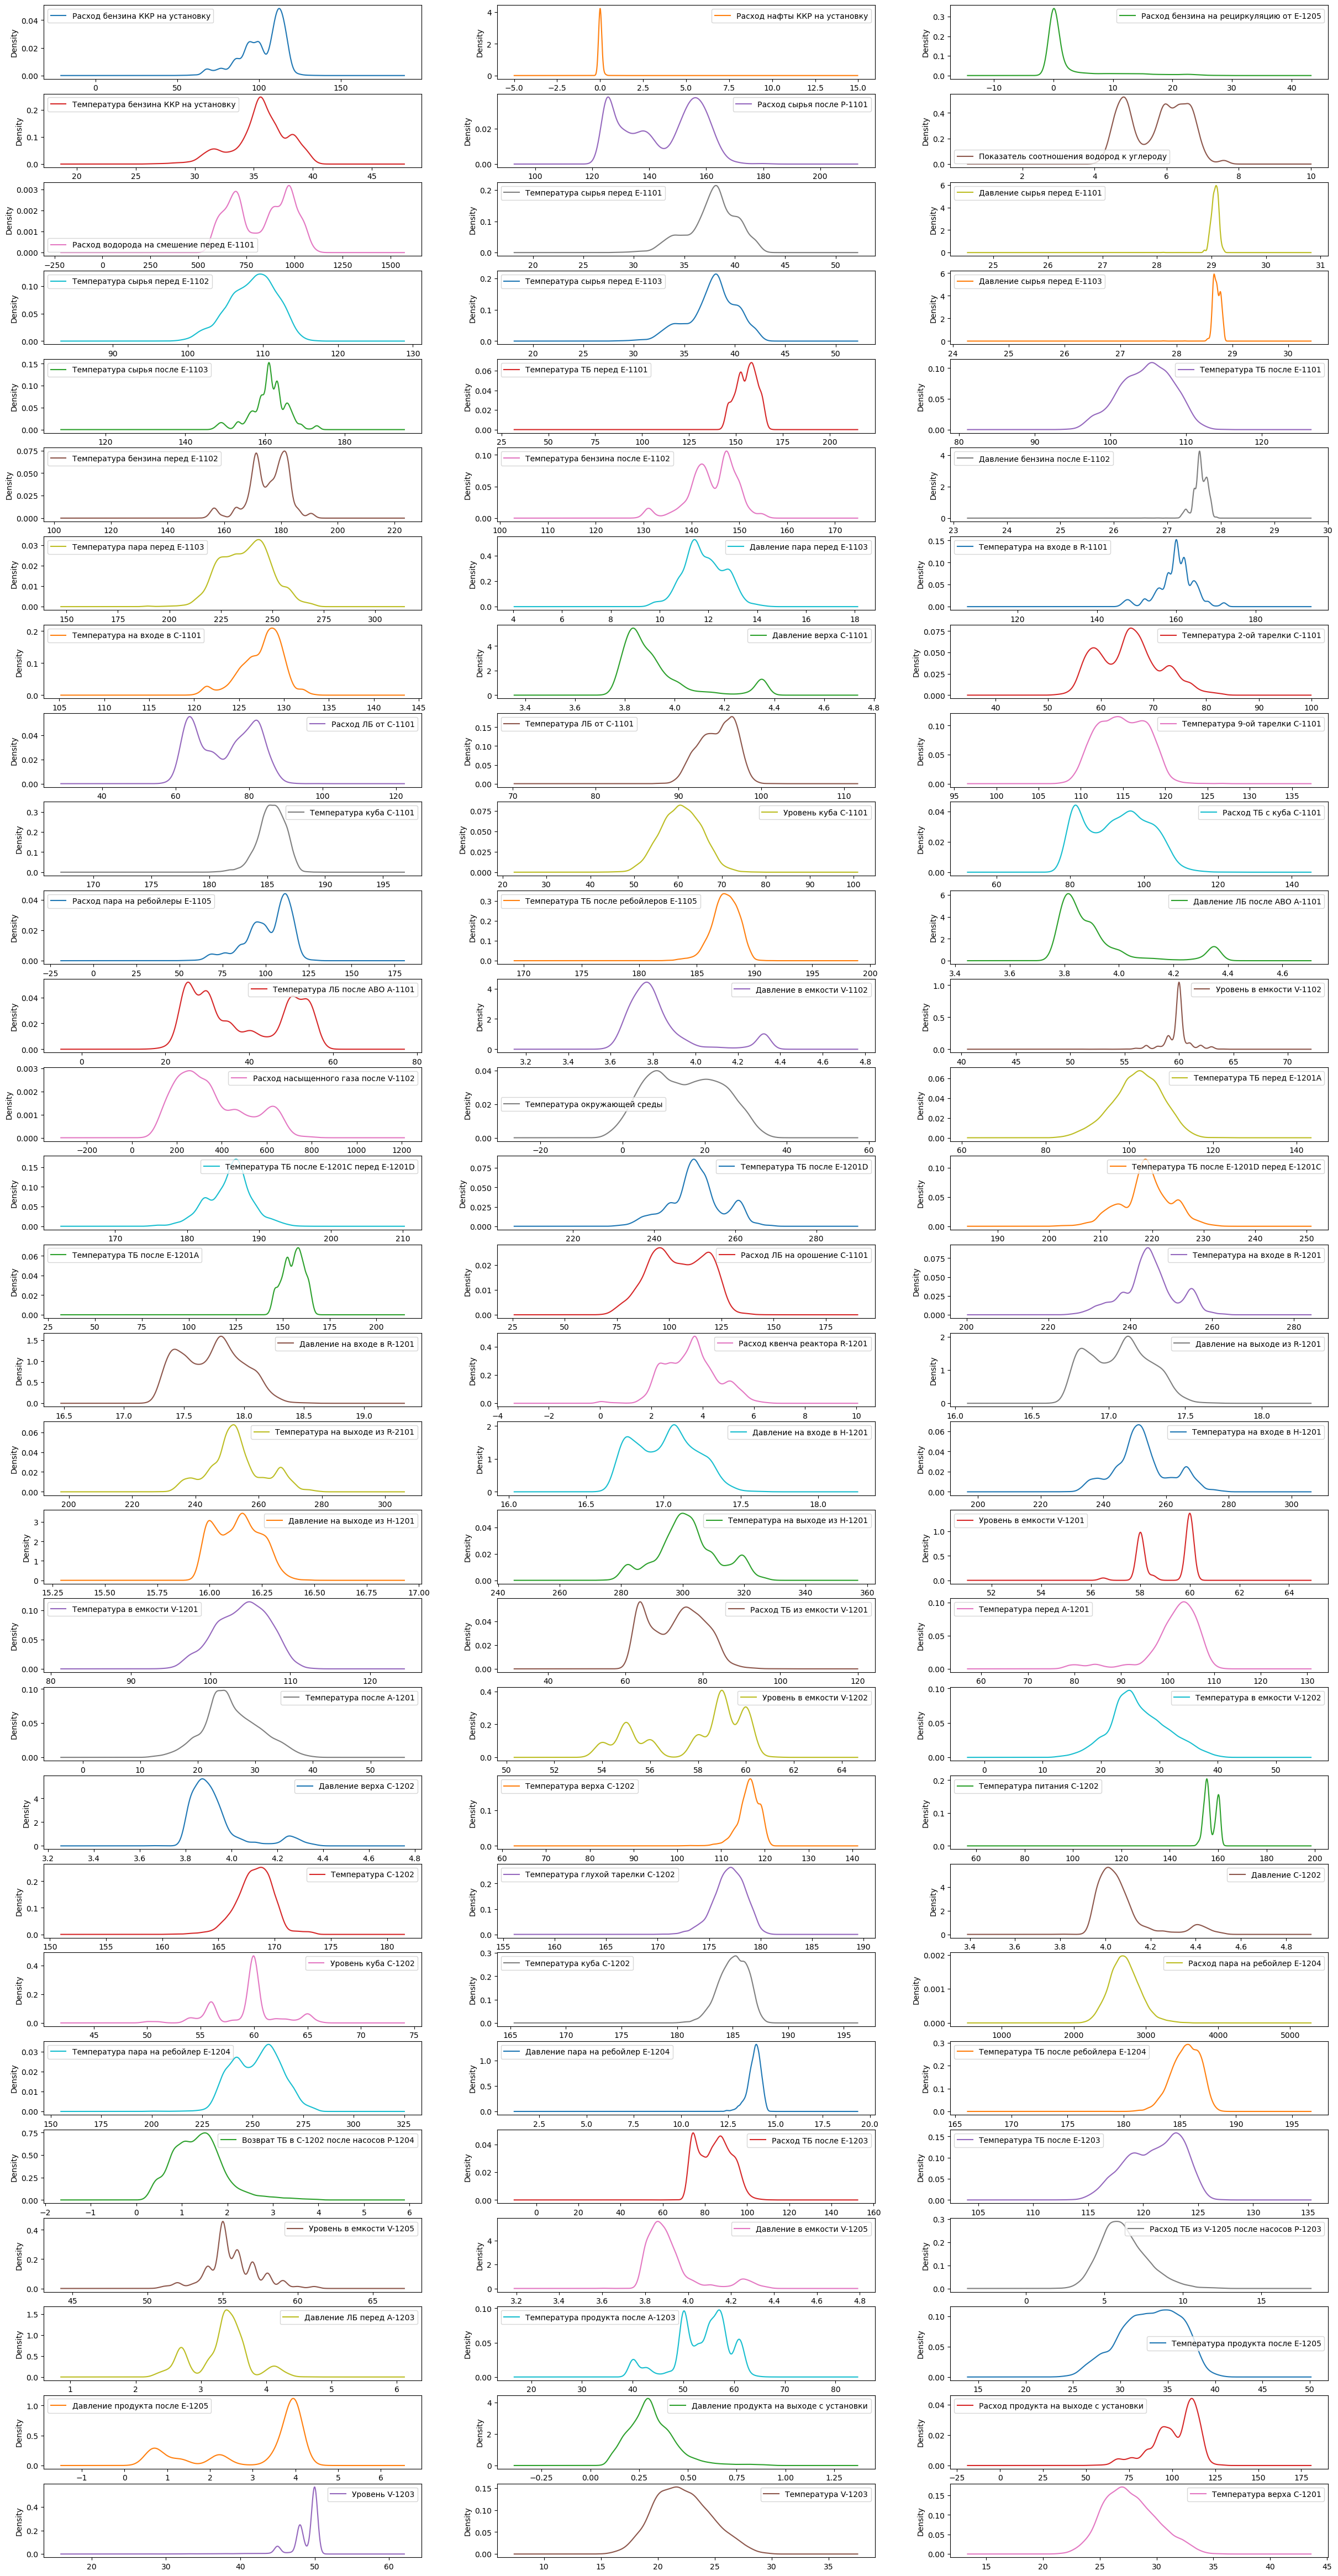

In [36]:
df_X1[df_X1.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X2

In [37]:
df_info_X2 = dataframe_info(df_X2)
df_info_X2

Расход бензина ККР на установку  \
variance                                 173.236973   
standart deviation                        13.161952   
mean                                     101.852943   
median                                   105.420000   
min                                       28.480000   
max                                      136.320000   

                    Расход нафты ККР на установку  \
variance                                 0.335407   
standart deviation                       0.579143   
mean                                     0.051745   
median                                   0.000000   
min                                      0.000000   
max                                      9.980000   

                    Расход бензина на рециркуляцию от Е-1205  \
variance                                           30.966677   
standart deviation                                  5.564771   
mean                                                2.614966   
median                                              0.000000   
min                                                 0.000000   
max                                                28.840000   

                    Температура бензина ККР на установку  \
variance                                        5.512290   
standart deviation                              2.347827   
mean                                           35.476018   
median                                         35.650000   
min                                            25.940000   
max                                            40.470000   

                    Давление в емкости V-1101  Расход сырья после Р-1101  \
variance                             0.000358                 187.978597   
standart deviation                   0.018928                  13.710529   
mean                                 1.195548                 143.887026   
median                               1.200000                 145.700000   
min                                  1.090000                 122.740000   
max                                  1.320000                 183.000000   

                    Показатель соотношения водород к углероду  \
variance                                             0.673476   
standart deviation                                   0.820656   
mean                                                 5.731032   
median                                               5.890000   
min                                                  2.860000   
max                                                  7.670000   

                    Расход водорода на смешение перед Е-1101  \
variance                                        22412.764344   
standart deviation                                149.708932   
mean                                              826.087096   
median                                            859.780000   
min                                               230.770000   
max                                              1124.950000   

                    Температура сырья перед Е-1101  \
variance                                  5.972179   
standart deviation                        2.443804   
mean                                     37.747321   
median                                   38.010000   
min                                      26.660000   
max                                      43.670000   

                    Давление сырья перед Е-1101  \
variance                               0.011504   
standart deviation                     0.107257   
mean                                  29.057929   
median                                29.070000   
min                                   26.100000   
max                                   29.250000   

                    Температура сырья после Е-1103  \
variance                                 20.122729   
standart deviation                        4.485837   
mean                                    160.949154   
m

In [38]:
drop_low_variance(df_X2, df_info_X2, min_var)

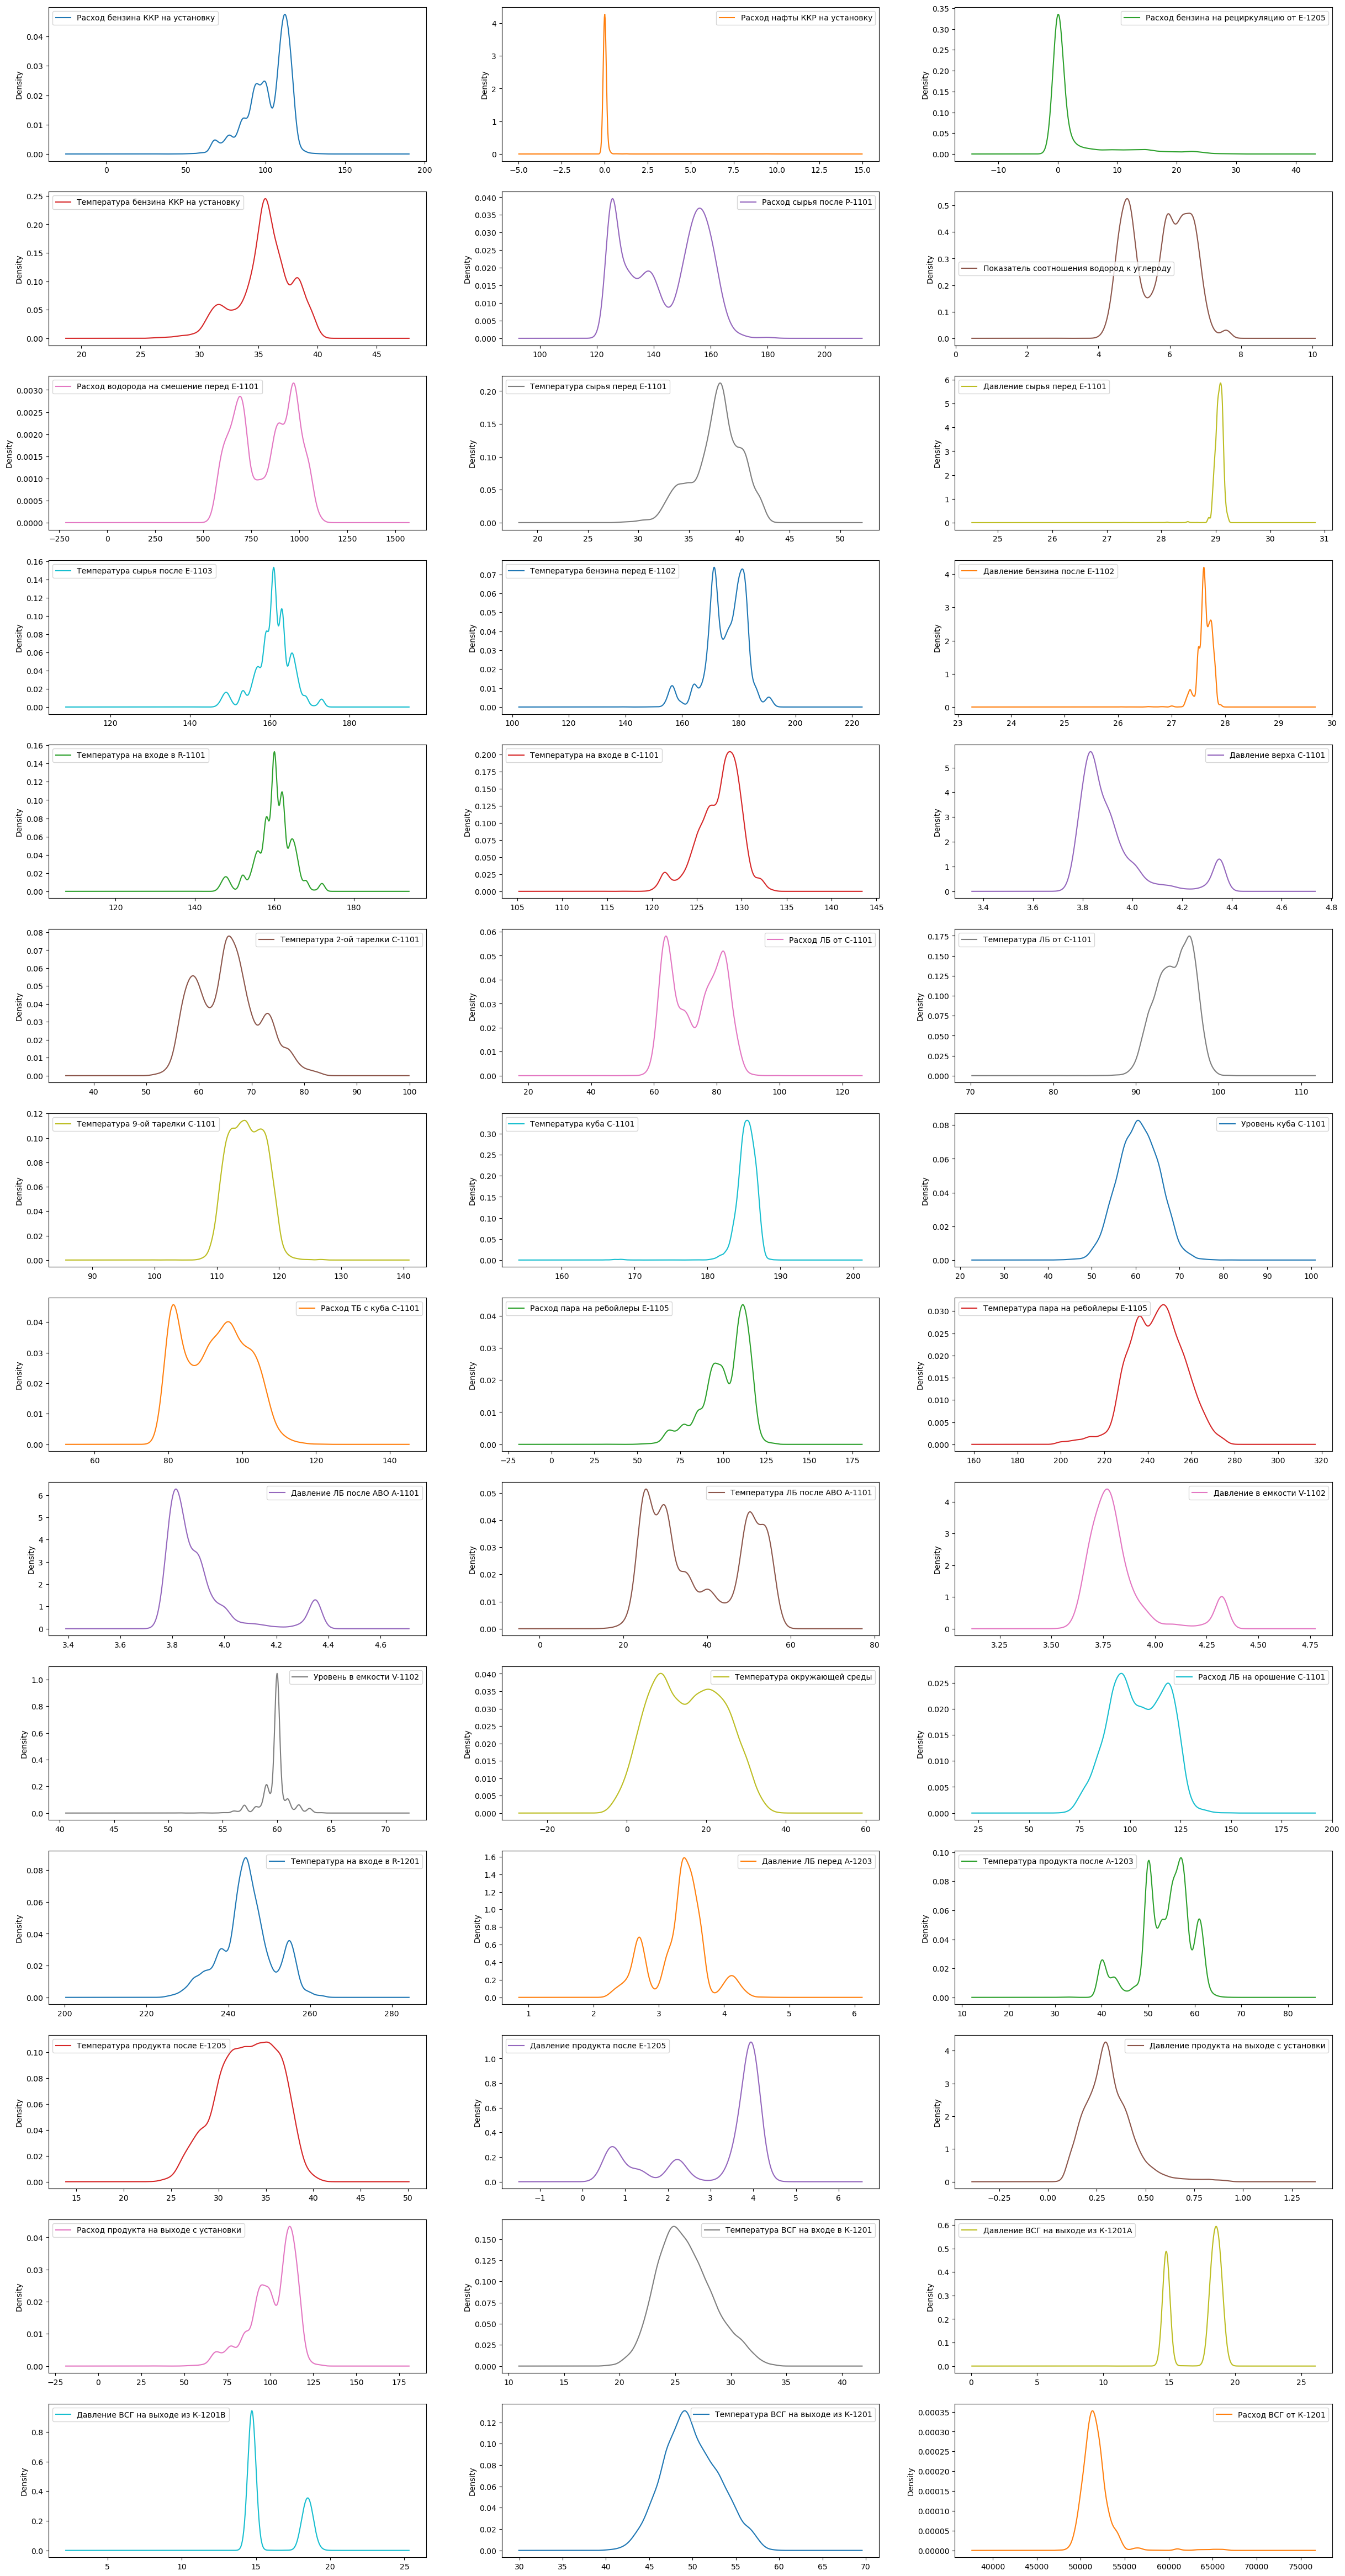

In [39]:
df_X2[df_X2.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X3

In [40]:
df_info_X3 = dataframe_info(df_X3)
df_info_X3

4FI3401_DACA_PV/Var/MV/Расход бензина ККР на установку/  \
variance                                                   168.905469         
standart deviation                                          12.996364         
mean                                                       102.170861         
median                                                     105.940000         
min                                                         31.360000         
max                                                        136.320000         

                    4FI3402_DACA_PV/Var/MV/Расход нафты ККР на установку/  \
variance                                                     0.339488       
standart deviation                                           0.582656       
mean                                                         0.052010       
median                                                       0.000000       
min                                                          0.000000       
max                                                          9.980000       

                    4FIC1002_PIDA_PV/Var/MV/Расход бензина на рециркуляцию от Е-1205/  \
variance                                                    29.974600                   
standart deviation                                           5.474906                   
mean                                                         2.533616                   
median                                                       0.000000                   
min                                                          0.000000                   
max                                                         28.840000                   

                    4TI1002_DACA_PV/Var/MV/Температура бензина ККР на установку/  \
variance                                                     5.431389              
standart deviation                                           2.330534              
mean                                                        35.538637              
median                                                      35.680000              
min                                                         25.940000              
max                                                         40.470000              

                    4PIC1035A_PIDA_PV/Var/MV/Давление в емкости V-1101/  \
variance                                                     0.000395     
standart deviation                                           0.019885     
mean                                                         1.195266     
median                                                       1.200000     
min                                                          1.090000     
max                                                          1.320000     

                    4FIC1010_PIDA_PV/Var/MV/Расход сырья после Р-1101/  \
variance                                                   187.830089    
standart deviation                                          13.705112    
mean                                                       144.154440    
median                                                     146.980000    
min                                                        122.740000    
max                                                        183.000000    

                    4FFIC1003_RATIOCTLA_SP/Var/MV/Показатель соотношения водород к углероду/  \
variance                                                     0.663450                          
standart deviation                                           0.814524                          
mean                                                         5.726272                          
median                                                       5.890000                          
min                                                          2.860000                          
max                                                          7.620000                       

In [41]:
drop_low_variance(df_X3, df_info_X3, min_var)

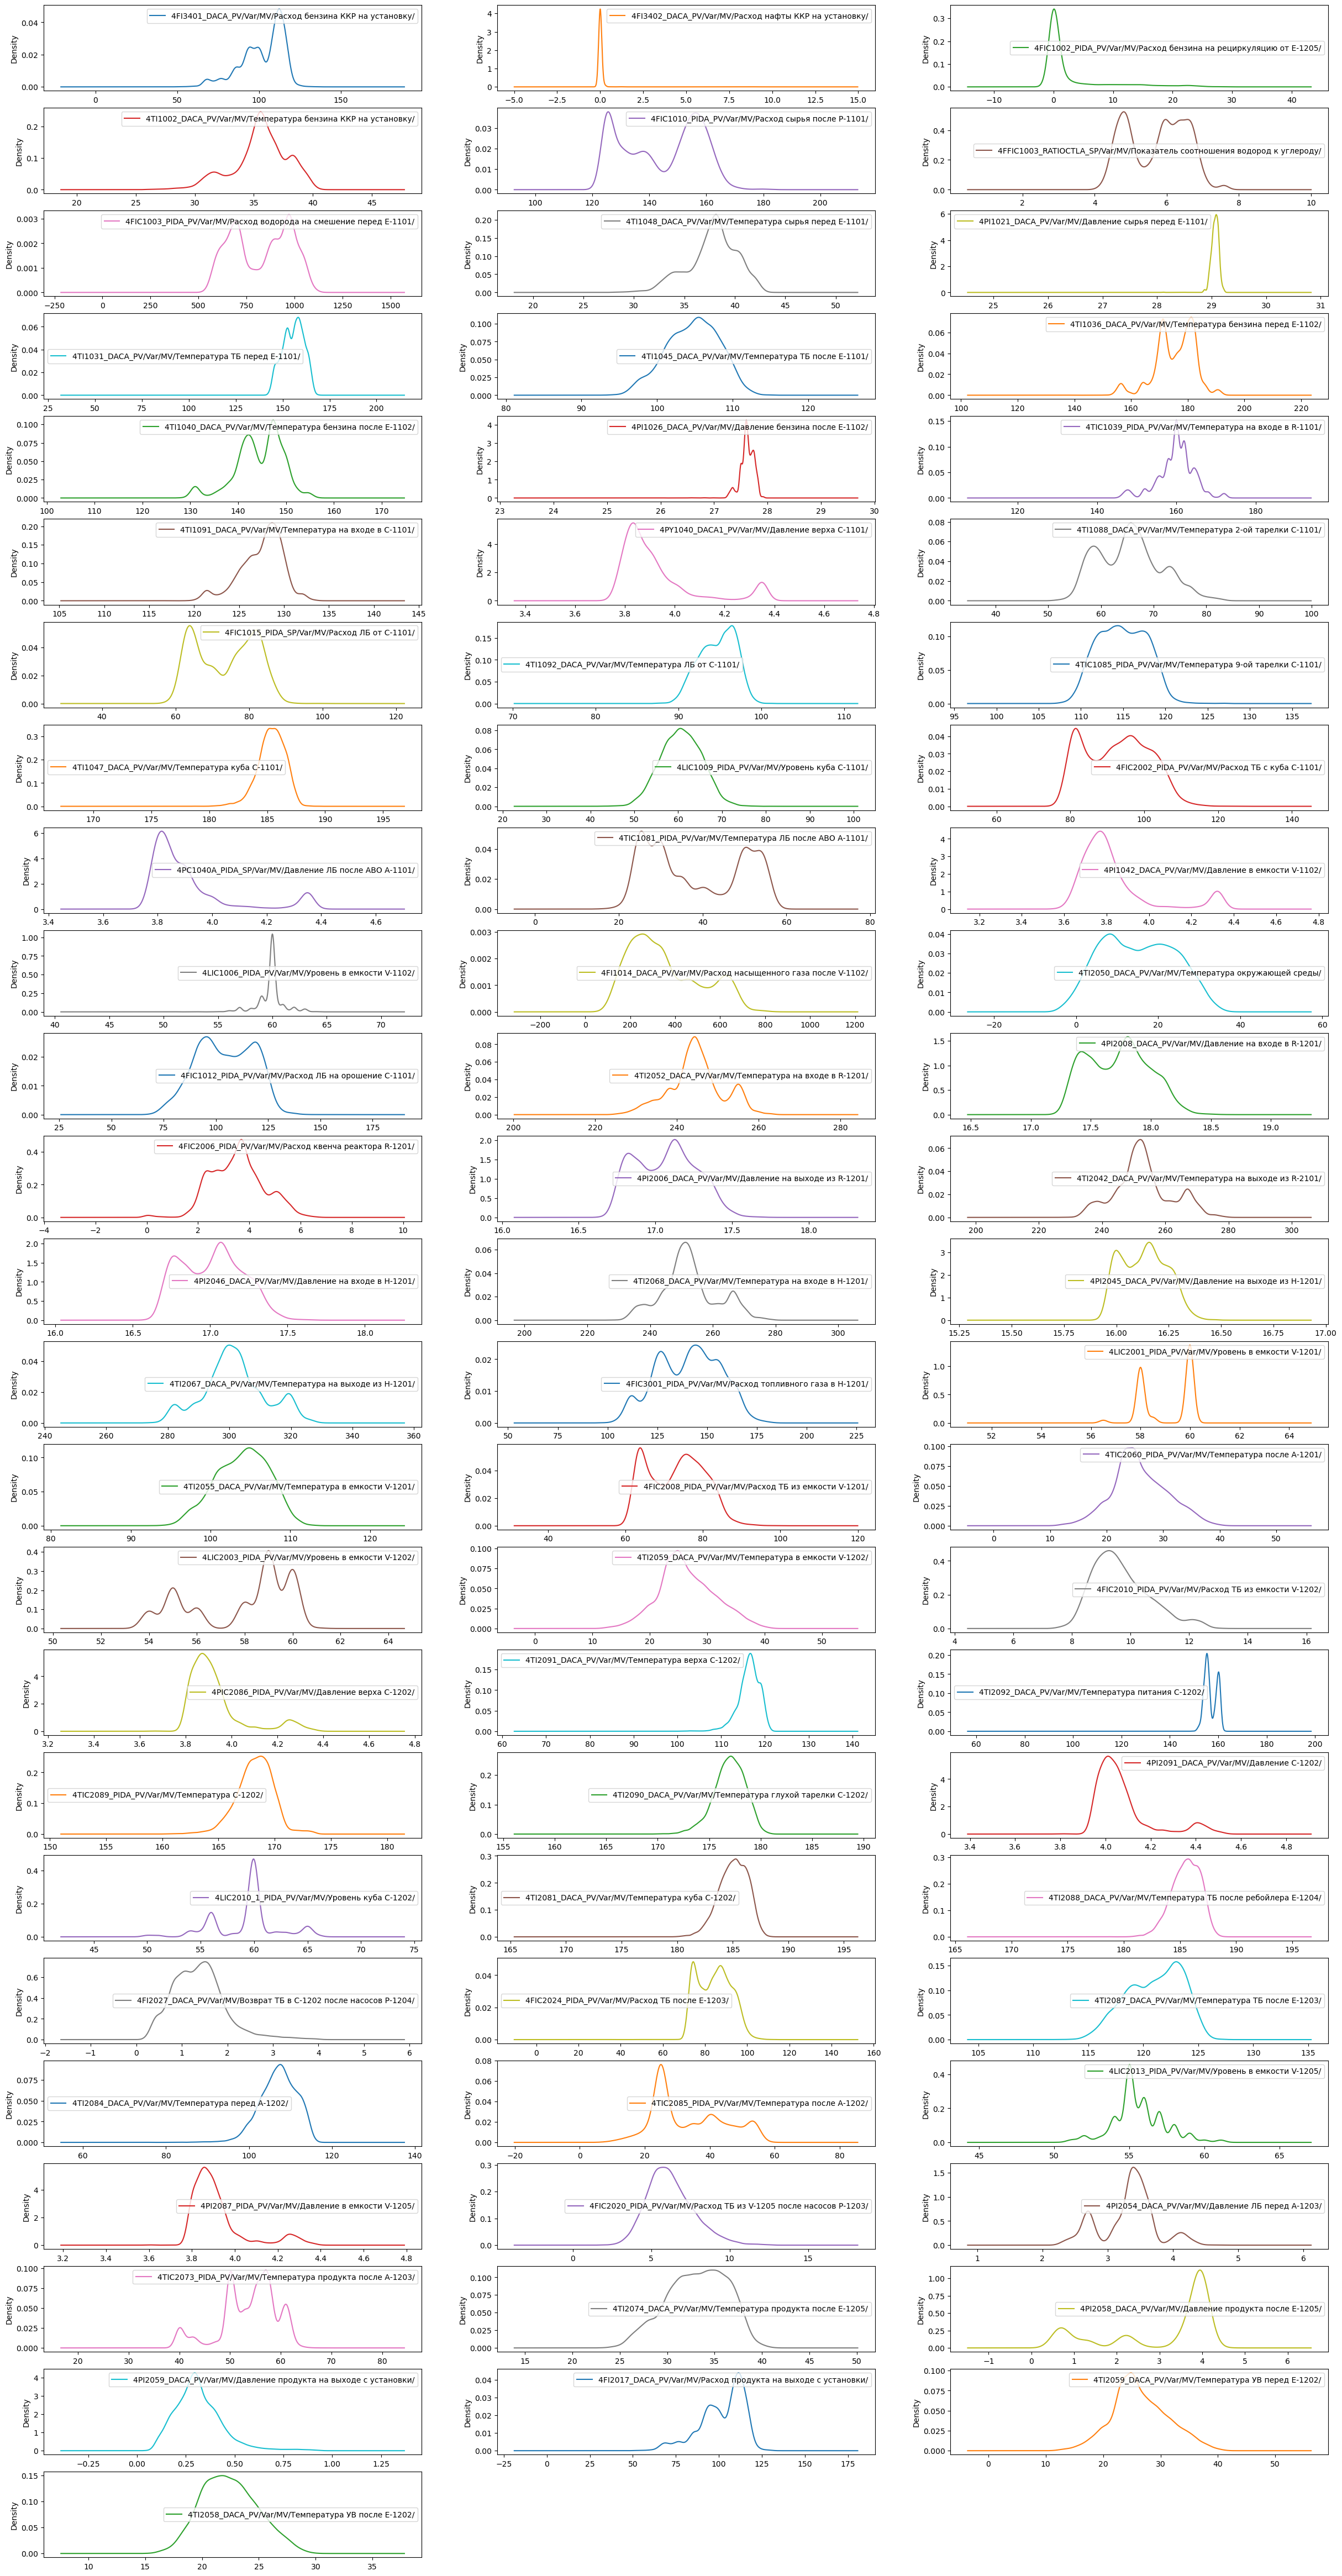

In [42]:
df_X3[df_X3.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

Посмотрим, какая регулярность измерений процессорных данных. Для этого построим гистограмму распределения временного промежутка (в минутах) между двумя соседними измерениями.
Лабораторные анализы проиводились крайне нерегулярно, для них такая диаграмма не имеет смысла.

Counter({Timedelta('0 days 01:27:55'): 5437, Timedelta('0 days 01:29:20'): 1914, Timedelta('0 days 01:25:00'): 1735, Timedelta('0 days 01:27:50'): 1471, Timedelta('0 days 01:00:00'): 880, Timedelta('0 days 02:55:50'): 18, Timedelta('0 days 02:55:40'): 8, Timedelta('0 days 04:23:45'): 8, Timedelta('0 days 05:51:40'): 7, Timedelta('0 days 07:19:35'): 6, Timedelta('0 days 04:28:00'): 6, Timedelta('0 days 02:50:00'): 5, Timedelta('0 days 00:11:15'): 4, Timedelta('0 days 05:51:20'): 4, Timedelta('0 days 04:15:00'): 3, Timedelta('0 days 04:23:30'): 3, Timedelta('0 days 08:56:00'): 3, Timedelta('0 days 05:57:20'): 3, Timedelta('0 days 09:55:00'): 2, Timedelta('0 days 07:05:00'): 2, Timedelta('0 days 22:40:00'): 2, Timedelta('0 days 02:27:50'): 2, Timedelta('0 days 07:26:40'): 2, Timedelta('0 days 02:58:40'): 2, Timedelta('0 days 00:27:55'): 2, Timedelta('0 days 01:11:15'): 2, Timedelta('0 days 08:47:30'): 2, Timedelta('0 days 11:20:00'): 1, Timedelta('0 days 00:45:00'): 1, Timedelta('3 days 2

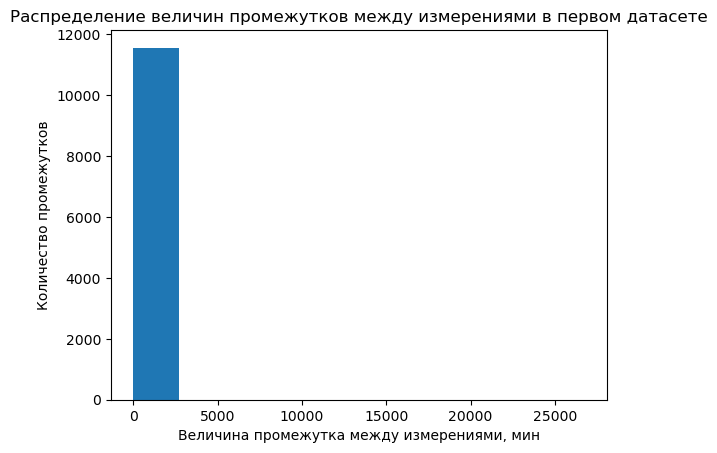

In [43]:
plot_timedelta_distr(df_X1, "Распределение величин промежутков между измерениями в первом датасете")

Как мы видим, даже процессорные измерения были не полностью регулярные, что может сказаться на количестве процессорных значений, соответствующих одному лабораторному анализу

Пройдёмся по нашим процессорным данным и поставим в соответствие лабораторным измерениям те процессорные данные, которые были получены не дальше чем diff времени до лабораторного анализа или diff2 времени после лабораторного анализа

In [44]:
diff1 = pd.to_timedelta('2h')
diff2 = pd.to_timedelta('4h')

Количество точек 134 

Распределение количества примеров 
 Counter({1: 57, 2: 50, 0: 27}) 



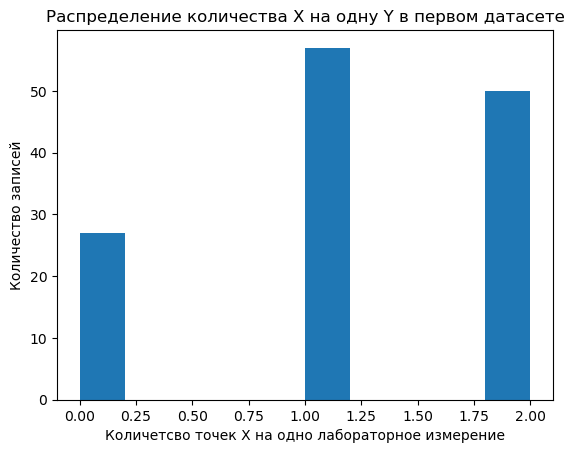

In [45]:
plot_num_distr(construct_XY(df_X1, df_Y1, diff1, diff2), "Распределение количества X на одну Y в первом датасете")

Количество точек 110 

Распределение количества примеров 
 Counter({1: 66, 2: 39, 0: 5}) 



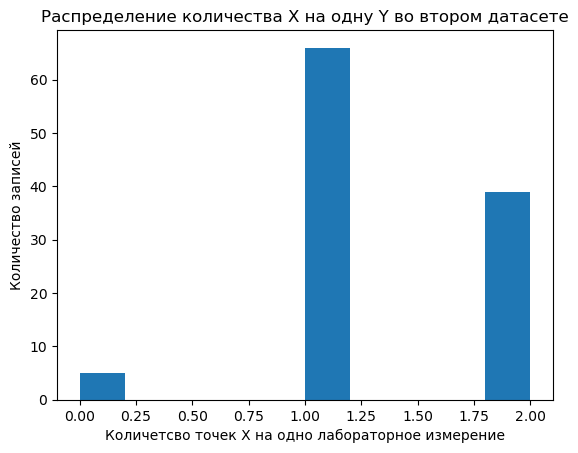

In [46]:
plot_num_distr(construct_XY(df_X2, df_Y2, diff1, diff2), "Распределение количества X на одну Y во втором датасете")

Количество точек 226 

Распределение количества примеров 
 Counter({1: 125, 2: 83, 0: 18}) 



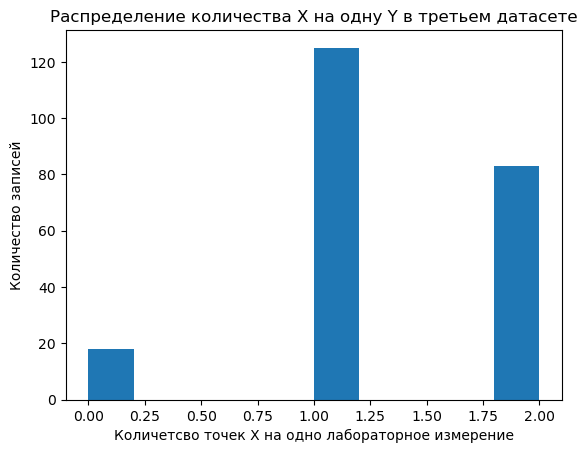

In [47]:
plot_num_distr(construct_XY(df_X3, df_Y3, diff1, diff2), "Распределение количества X на одну Y в третьем датасете")

Как мы видим, при данных временных рамках одному лабораторному анализу может соответствовать от нуля до пяти процессорных данных. Чтобы иметь возможность адекватно обрабатывать данные, необходимо отбросить точки без процессорных данных и свести процессорные данные к единому формату. 
Подобная обработка процессорных данных может быть проделана, используя среднее или экпоенециальное среднее

## Формирование тестовой и обучающей выборки

## Описание функций

Функция формирования тестовой и обучающей выборки в numpy массивов, значения Х в каждой точке агрегируются в вектор. На вход подаётся свежий экземпляр генератора точек X и Y и функция агрегирования

In [48]:
def form_datasets(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    return all_X, all_Y_with_timestamps

def form_datasets_periods(gen, agregate_func) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Формирует 2 numpy.ndarray в порядке x_summer_half, y_summer_half, x_winter_half, y_winter_half,
    значения X получены через функцию агрегирования agregate_func."""

    # Получение первой порции данных из генератора для определения размеров массивов
    try:
        x, y, timestamp = next(gen)  
    except StopIteration:
        # Если генератор не возвращает данных, завершаем функцию и возвращаем пустые массивы
        return (np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0))

    # Инициализируем массивы для записи данных
    x_summer_half = np.array([], dtype=np.float64).reshape(0, x.shape[1])
    x_winter_half = np.array([], dtype=np.float64).reshape(0, x.shape[1])
    y_summer_half = np.array([], dtype='object').reshape(0, len(y) + 1)
    y_winter_half = np.array([], dtype='object').reshape(0, len(y) + 1)

    # Обрабатываем оставшиеся данные
    for x, y, timestamp in gen:
        if len(x) == 0:
            continue
        
        x_agg = agregate_func(x)

        # Распределение данных по выборкам в зависимости от месяца
        if 4 <= timestamp.month <= 9:
            y_summer_half = np.vstack((y_summer_half, np.append(y, timestamp)))
            x_summer_half = np.vstack((x_summer_half, x_agg))
        else:
            y_winter_half = np.vstack((y_winter_half, np.append(y, timestamp)))
            x_winter_half = np.vstack((x_winter_half, x_agg))

    return x_summer_half, y_summer_half, x_winter_half, y_winter_half

def form_datasets_cat(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []
    all_X_season = []  # Создаем список для сезонного столбца

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)
            # Добавляем значение в список сезонного столбца
            all_X_season.append(1 if 4 <= timestamp.month <= 9 else 0)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)
    all_X_season = np.array(all_X_season, dtype=np.float64).reshape(-1, 1)  # Преобразуем список в массив NumPy

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    # Добавляем сезонный столбец к all_X
    all_X = np.hstack((all_X, all_X_season))

    return all_X, all_Y_with_timestamps

Функция агрегирования, обобщающая использование арифметического среднего, последнего значения и взвешенного экпоненциального среднего

In [49]:
def exp_average(arr: np.ndarray, alpha=0) -> np.ndarray:
    """Функция взвешенного среднего для агрегирования значений X. При alpha = 0 результат - арифметическое среднее, 
    при alpha = 1 результат - последнее значение, при alpha = (0, 1) результат - экспоненциальное взвешенное среднее"""

    arr = arr[::-1]
    out_arr = np.zeros(arr.shape[1])
    coeff_sum = 0
    for pow, row in enumerate(arr):
        coeff = (1-alpha)**pow
        out_arr = out_arr + row*coeff
        coeff_sum += coeff
    
    out_arr = out_arr/coeff_sum
    return out_arr

Сохранение данных в .npz архив

In [50]:
def save_datasets(gen1, gen2, gen3, gen2_cat, gen3_cat, func, func_name) -> None:
    """Генерирует и сохраняет датасеты с определённой функцией агрегирования func в .npz архив под именем Data_func_name.npz"""
    
    all_X_1, all_Y_1 = form_datasets(gen1, func)
    x_summer_half_2, y_summer_half_2, x_winter_half_2, y_winter_half_2 = form_datasets_periods(gen2, func)
    x_summer_half_3, y_summer_half_3, x_winter_half_3, y_winter_half_3 = form_datasets_periods(gen3, func)
    all_X_2, all_Y_2 = form_datasets_cat(gen2_cat,func)
    all_X_3, all_Y_3 = form_datasets_cat(gen3_cat,func)
    
    np.savez_compressed(
        "Data_" + func_name +".npz", 
        all_X_1 = all_X_1, all_Y_1=all_Y_1, 
        x_summer_half_2=x_summer_half_2, y_summer_half_2=y_summer_half_2, x_winter_half_2=x_winter_half_2, y_winter_half_2=y_winter_half_2,
        x_summer_half_3=x_summer_half_3, y_summer_half_3=y_summer_half_3, x_winter_half_3=x_winter_half_3, y_winter_half_3=y_winter_half_3,
        all_X_2 = all_X_2, all_Y_2 = all_Y_2,
        all_X_3 = all_X_3, all_Y_3 = all_Y_3
    )
                       

## Сохранение размеченных данных

Сохраним архивы с 3 вариантами агрегирования (арифметическое среднее, последнее измерение, взвешенное экспоненциальное среднее. 

В каждом архиве находятся по 4 массива для 3 виртуальных анализаторов. Номер ВА - последняя цифра в названии массива (1 - Давление насыщенных паров в продукте, зимний период, 2 - Конец кипения легкого бензина, 3 - Содержание олефинов в продукте). 

Каждый массив построен по следующему принципу Y[N], X[N, C], где N - номер точки, C - номер процессорного значения.

In [51]:

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    lambda x: exp_average(x, alpha=0),
    "Average_Nikita"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    lambda x: exp_average(x, alpha=1),
    "First_Nikita"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    lambda x: exp_average(x, alpha=0.5),
    "Exponential_Average_Nikita"
)

In [52]:
df_X1.to_csv('raw_X1.csv')
df_X2.to_csv('raw_X2.csv')
df_X3.to_csv('raw_X3.csv')

df_Y1.to_csv('raw_Y1.csv')
df_Y2.to_csv('raw_Y2.csv')
df_Y3.to_csv('raw_Y3.csv')